### Question 1: Version of MLflow

In [1]:
!mlflow --version

mlflow, version 2.3.2


### Question 2: Size of the DictVectorizer file

In [2]:
!python preprocess_data.py --raw_data_path ./data --dest_path ./output

In [3]:
!ls -lh ./output/dv.pkl

-rw-r--r--  1 vchulski  staff   150K May 30 18:30 ./output/dv.pkl


### Question 3: Value of the max_depth parameter

`train.py`

```import os
import pickle
import click

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc_taxi_train_rf")
mlflow.autolog()


def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


@click.command()
@click.option(
    "--data_path",
    default="./output",
    help="Location where the processed NYC taxi trip data was saved",
)
def run_train(data_path: str):
    with mlflow.start_run():
        X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
        X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

        rf = RandomForestRegressor(max_depth=10, random_state=0) # <----- Here is the answer
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)

        rmse = mean_squared_error(y_val, y_pred, squared=False)


if __name__ == "__main__":
    run_train()
```


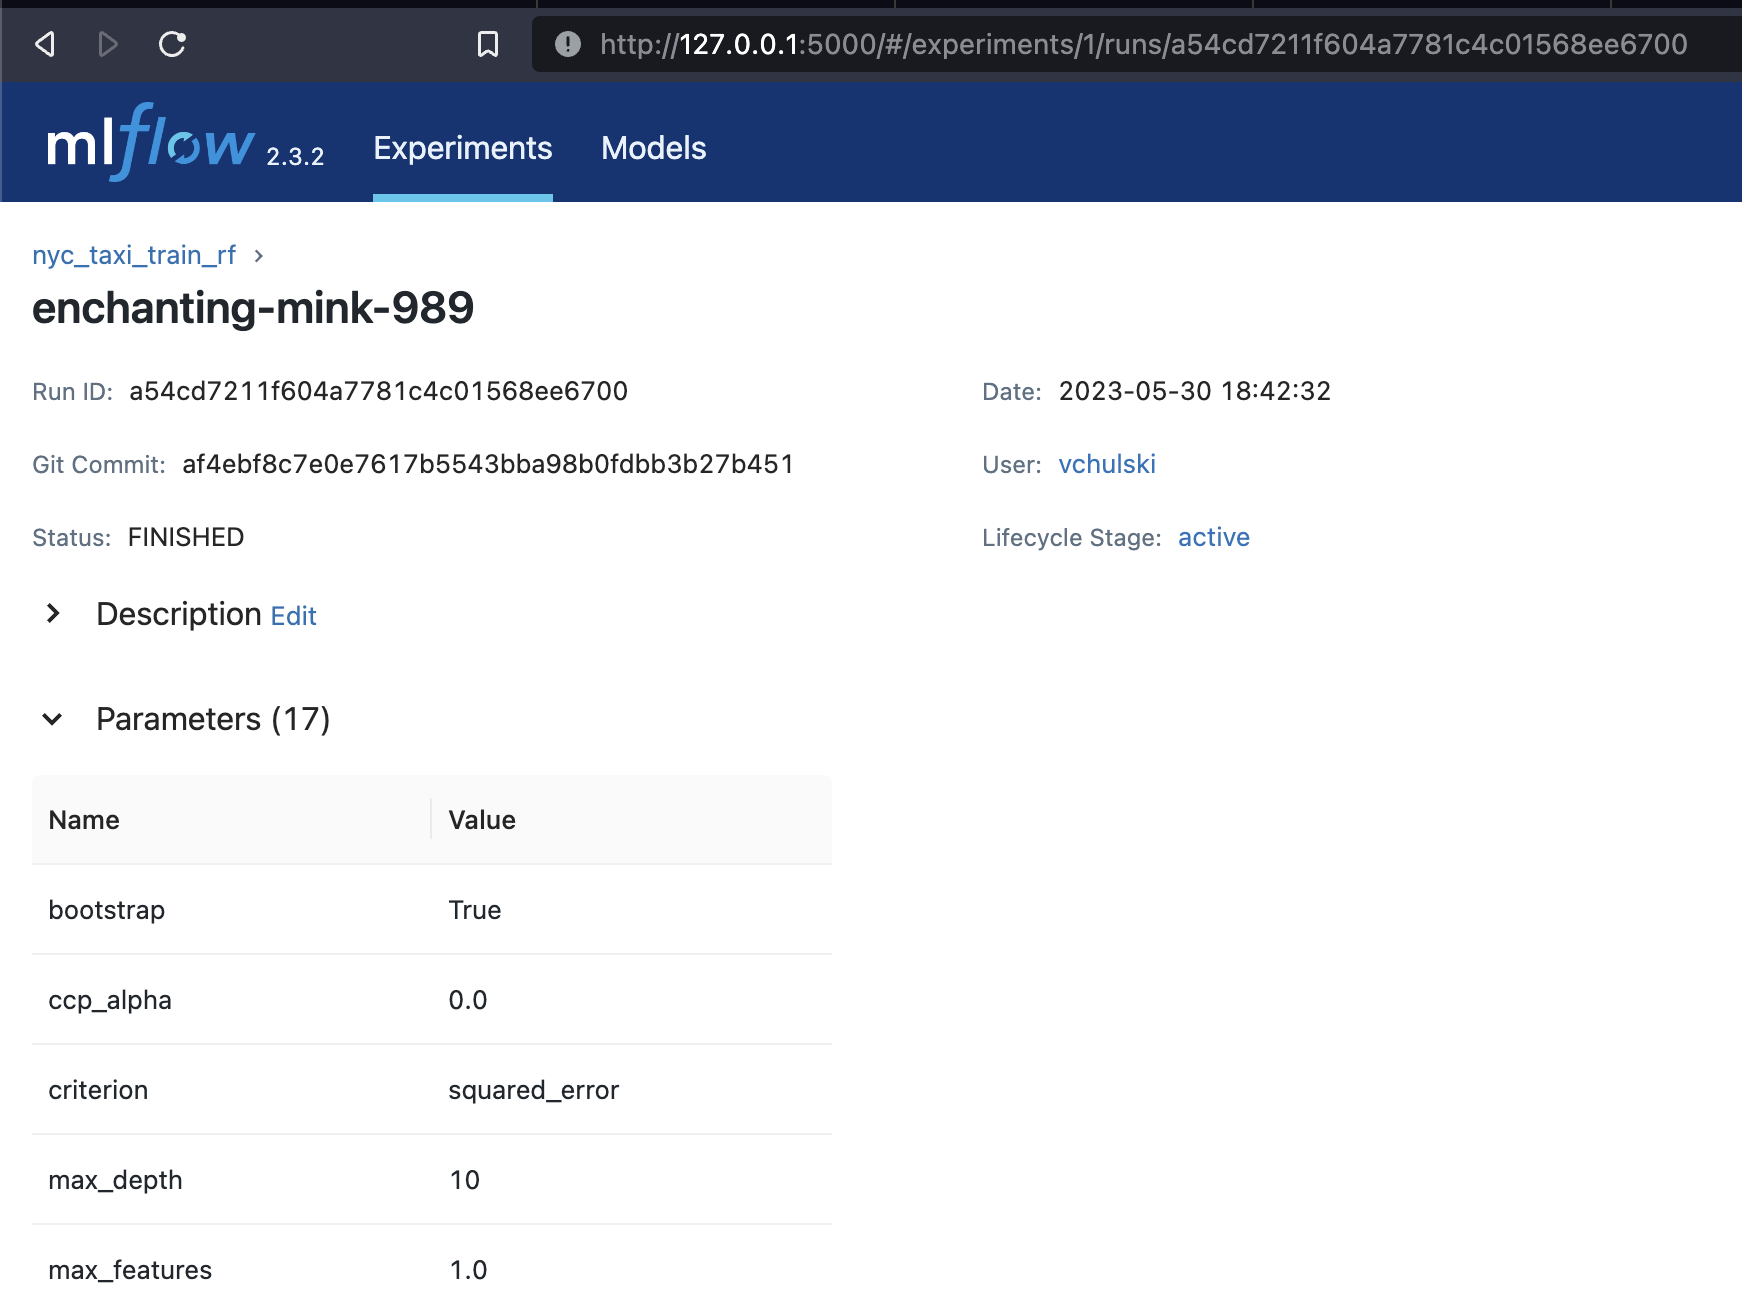

### Q4. Tune model hyperparameters (What's the best validation RMSE that you got?)

`hpo.py`

```import os
import pickle
import click
import mlflow
import optuna

from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("random-forest-hyperopt")


def load_pickle(filename):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


@click.command()
@click.option(
    "--data_path",
    default="./output",
    help="Location where the processed NYC taxi trip data was saved",
)
@click.option(
    "--num_trials",
    default=10,
    help="The number of parameter evaluations for the optimizer to explore",
)
def run_optimization(data_path: str, num_trials: int):
    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 10, 50, 1),
            "max_depth": trial.suggest_int("max_depth", 1, 20, 1),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 1),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1),
            "random_state": 42,
            "n_jobs": -1,
        }

        with mlflow.start_run():
            mlflow.log_params(params)

            rf = RandomForestRegressor(**params)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_val)
            rmse = mean_squared_error(y_val, y_pred, squared=False)

            mlflow.log_metric("rmse", rmse)

        return rmse

    sampler = TPESampler(seed=42)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=num_trials)


if __name__ == "__main__":
    run_optimization()
```

![Screenshot 2023-05-30 at 18.58.18.png](<attachment:Screenshot 2023-05-30 at 18.58.18.png>)
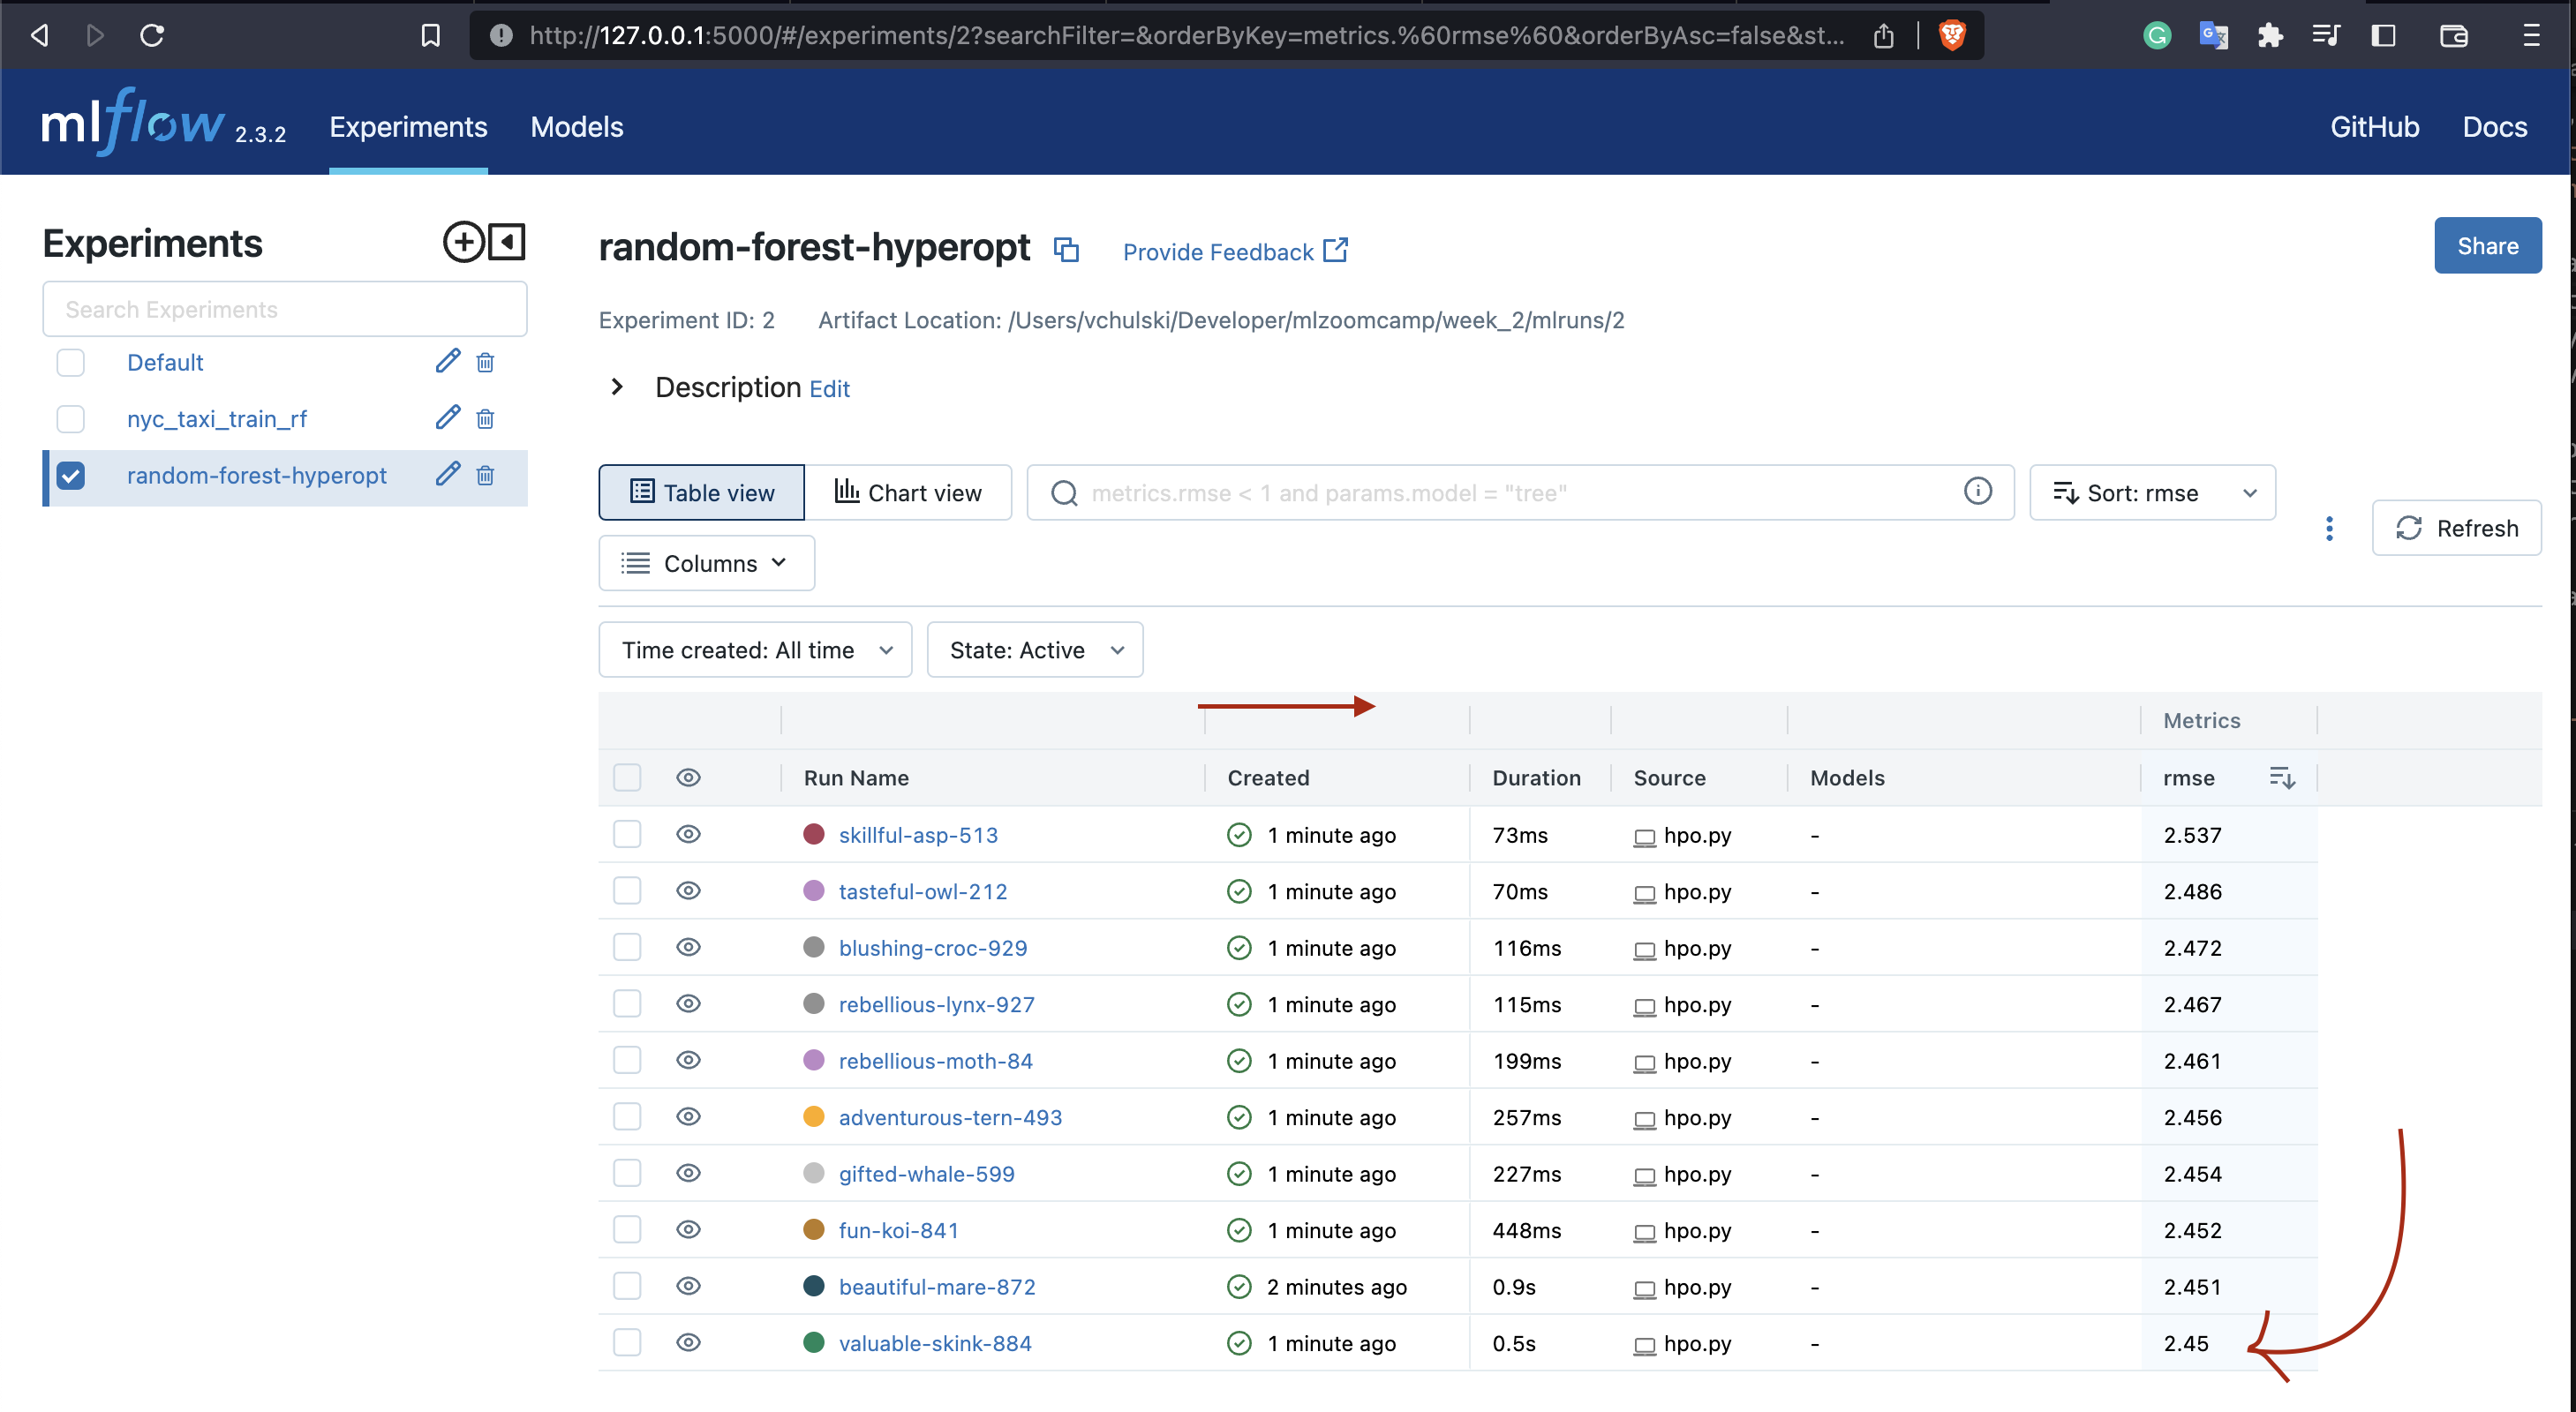

### Q5. Promote the best model to the model registry (RMSE on test)


``` register_model.py


import os
import pickle
import click
import mlflow

from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

HPO_EXPERIMENT_NAME = "random-forest-hyperopt"
EXPERIMENT_NAME = "random-forest-best-models_v3"
RF_PARAMS = [
    "max_depth",
    "n_estimators",
    "min_samples_split",
    "min_samples_leaf",
    "random_state",
    "n_jobs",
]

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.sklearn.autolog()


def load_pickle(filename):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


def train_and_log_model(data_path, params):
    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))
    X_test, y_test = load_pickle(os.path.join(data_path, "test.pkl"))

    with mlflow.start_run():
        for param in RF_PARAMS:
            params[param] = int(params[param])

        rf = RandomForestRegressor(**params)
        rf.fit(X_train, y_train)

        # Evaluate model on the validation and test sets
        val_rmse = mean_squared_error(y_val, rf.predict(X_val), squared=False)
        mlflow.log_metric("val_rmse", val_rmse)
        test_rmse = mean_squared_error(y_test, rf.predict(X_test), squared=False)
        mlflow.log_metric("test_rmse", test_rmse)


@click.command()
@click.option(
    "--data_path",
    default="./output",
    help="Location where the processed NYC taxi trip data was saved",
)
@click.option(
    "--top_n",
    default=5,
    type=int,
    help="Number of top models that need to be evaluated to decide which one to promote",
)
def run_register_model(data_path: str, top_n: int):
    client = MlflowClient()

    # Retrieve the top_n model runs and log the models
    experiment = client.get_experiment_by_name(HPO_EXPERIMENT_NAME)
    runs = client.search_runs(
        experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=top_n,
        order_by=["metrics.test_rmse ASC"],
    )
    for run in runs:
        train_and_log_model(data_path=data_path, params=run.data.params)

    # Select the model with the lowest test RMSE
    experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
    best_run = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        max_results=top_n,
        order_by=["metrics.test_rmse ASC"],
    )[0]

    # Register the best model
    mlflow.register_model(
        model_uri=f"runs:/{best_run.info.run_id}/model",
        name="nyc-taxi-optimized-regressor_v3",
    )


if __name__ == "__main__":
    run_register_model()


```

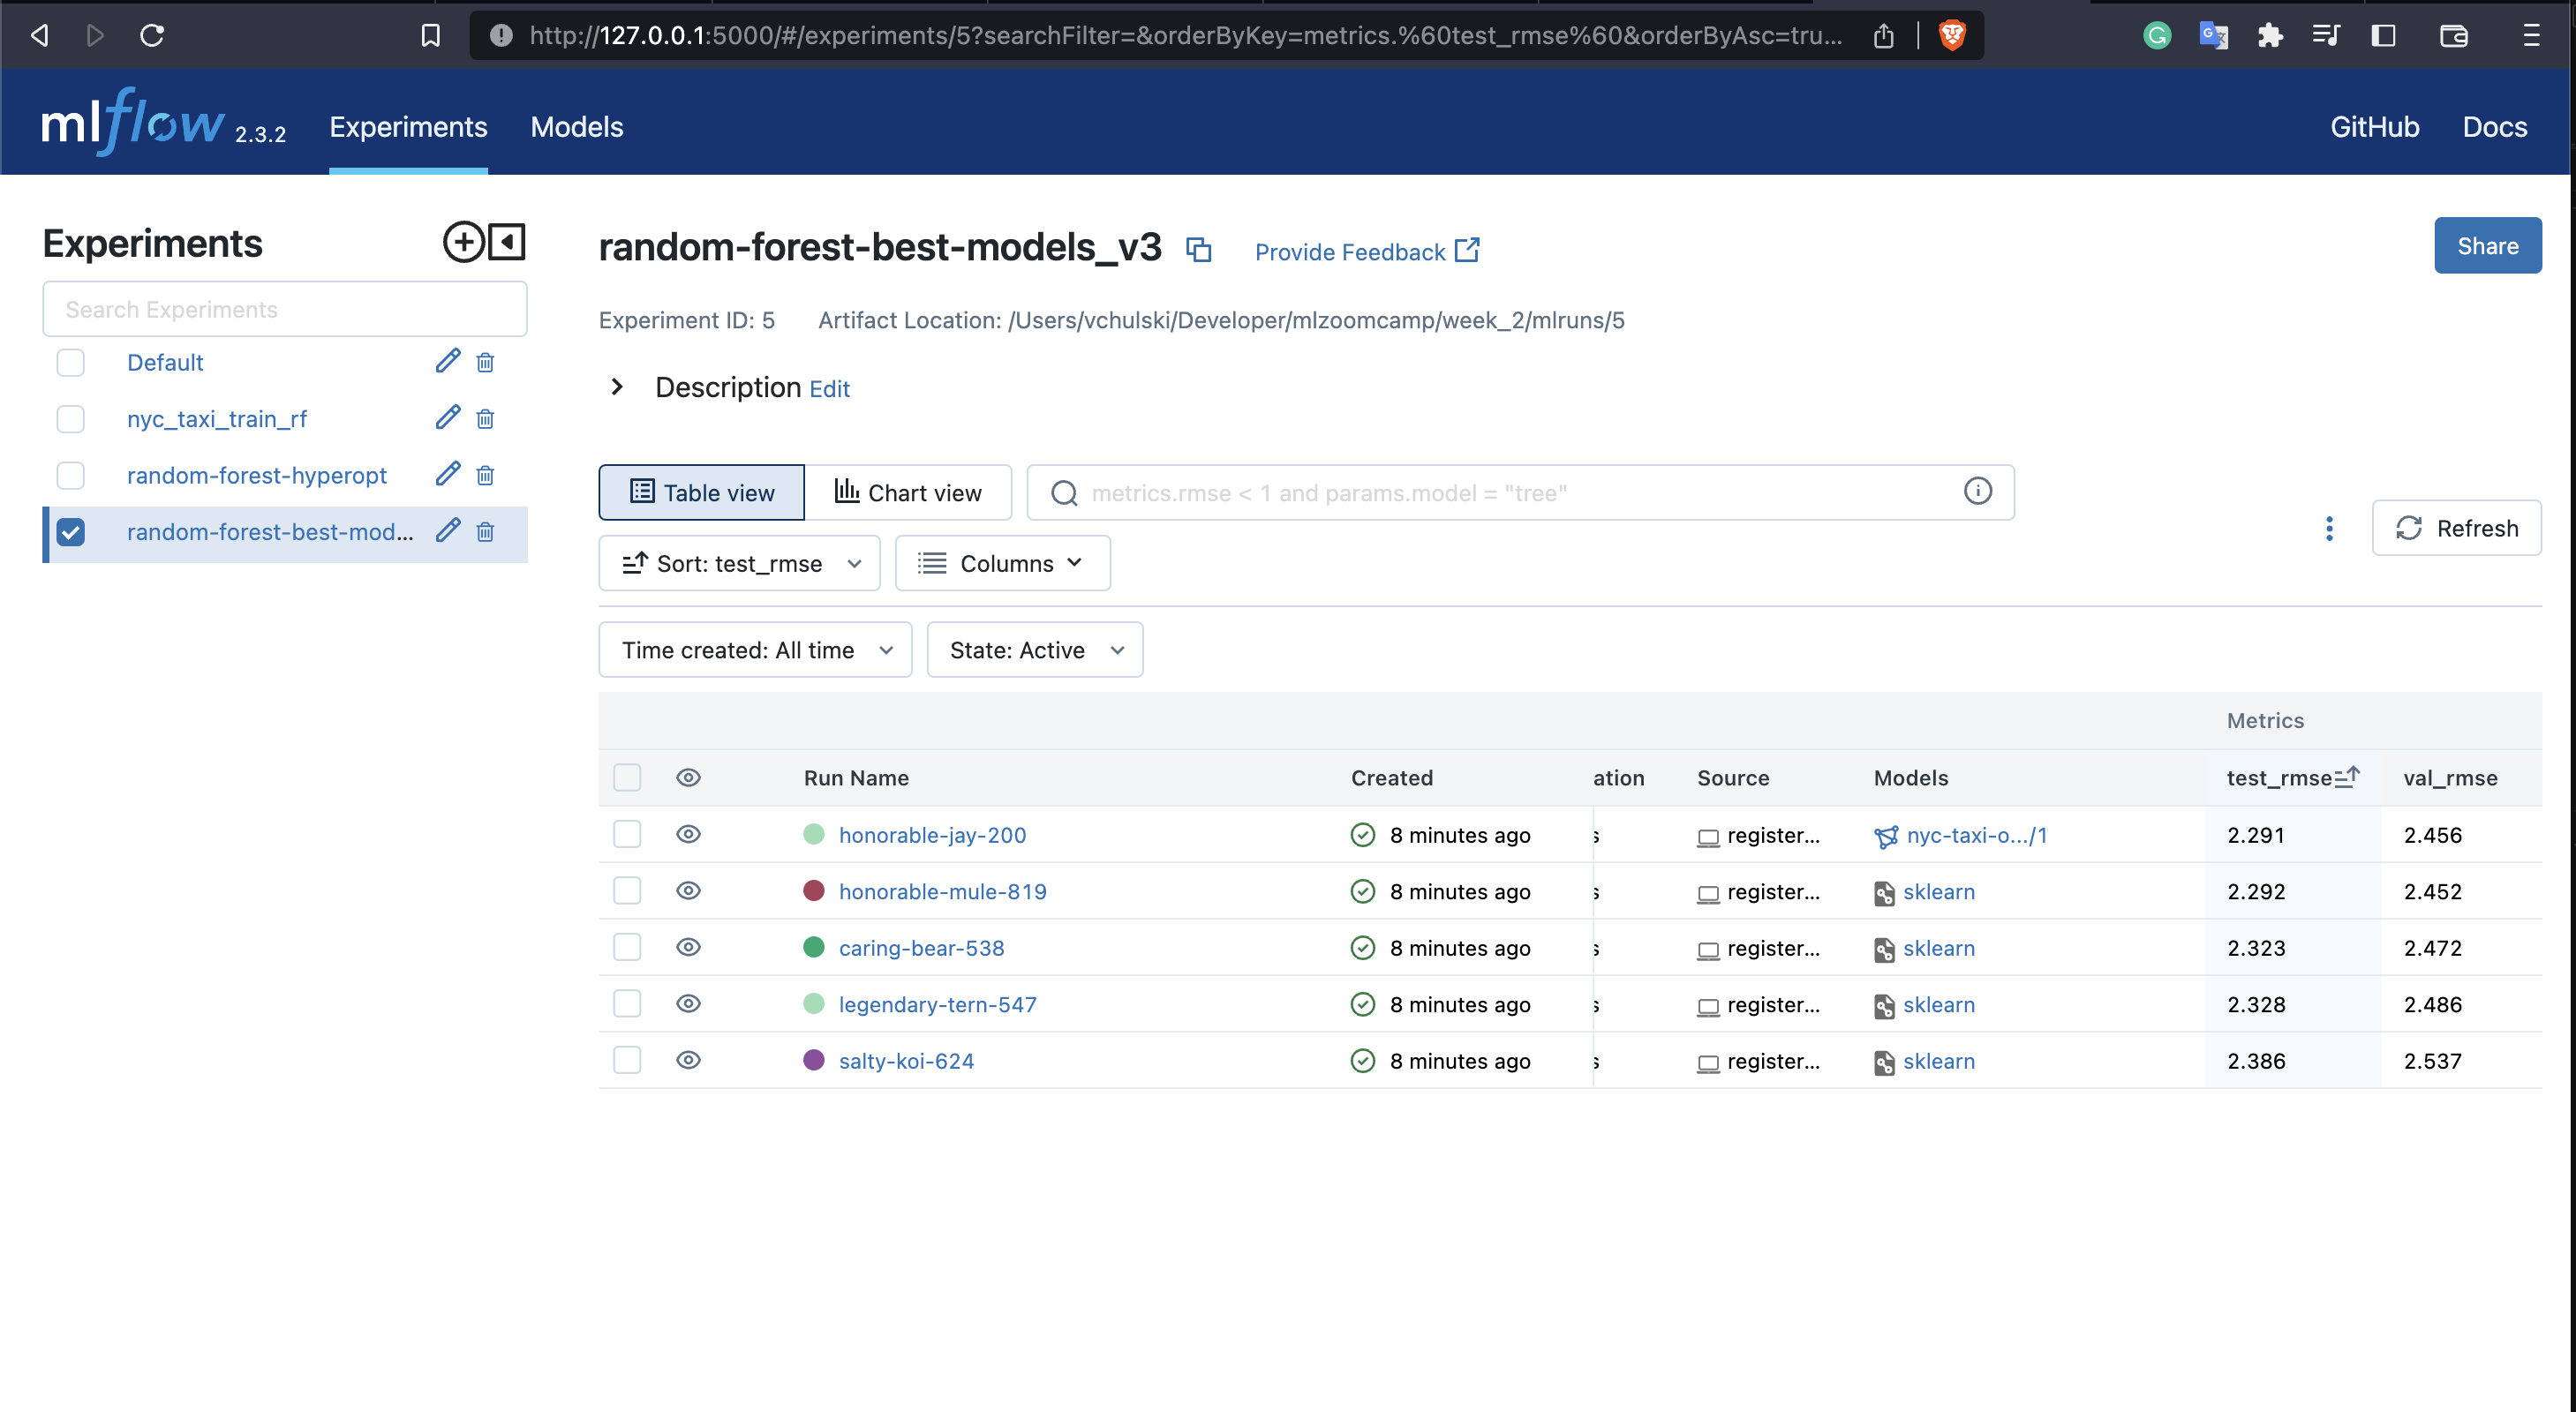

#### I didn't get the precise value listed as options, but I've chosen the nearest

### Question 6: Information that model registry contains about each model


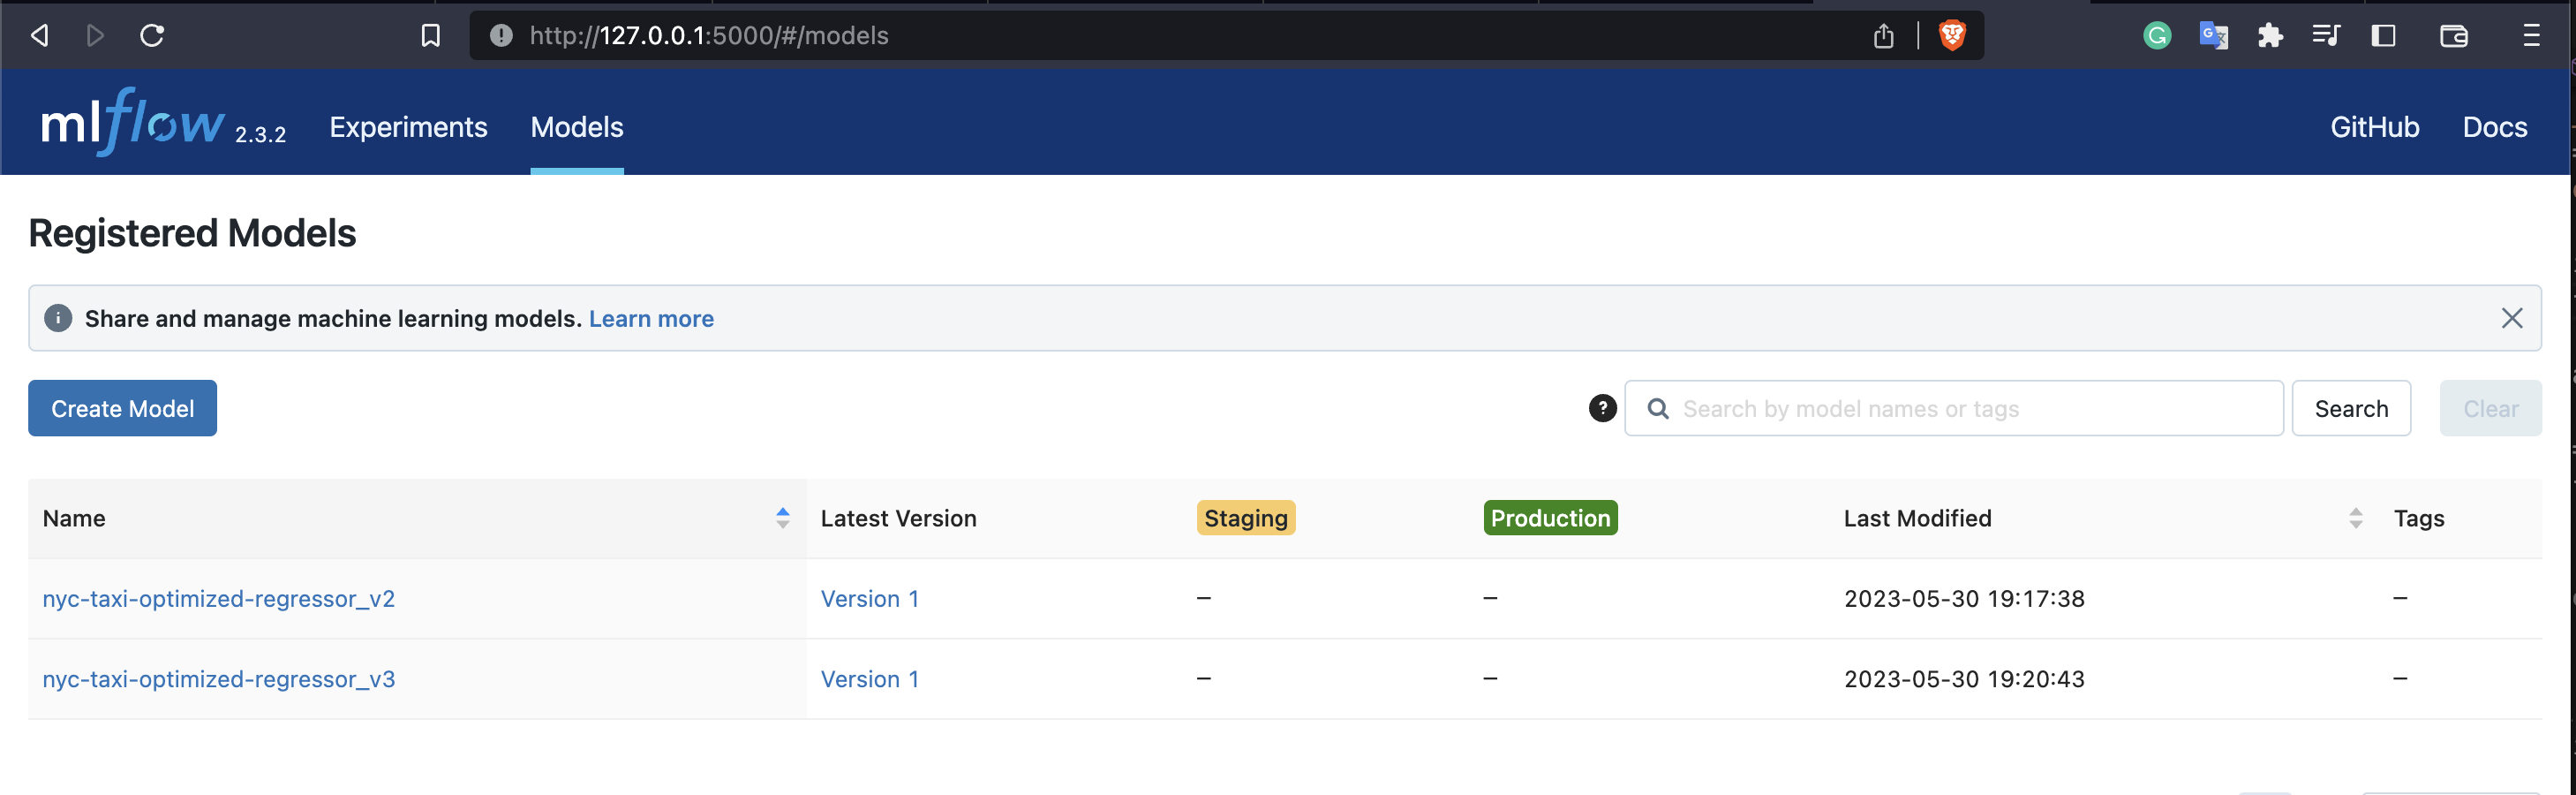

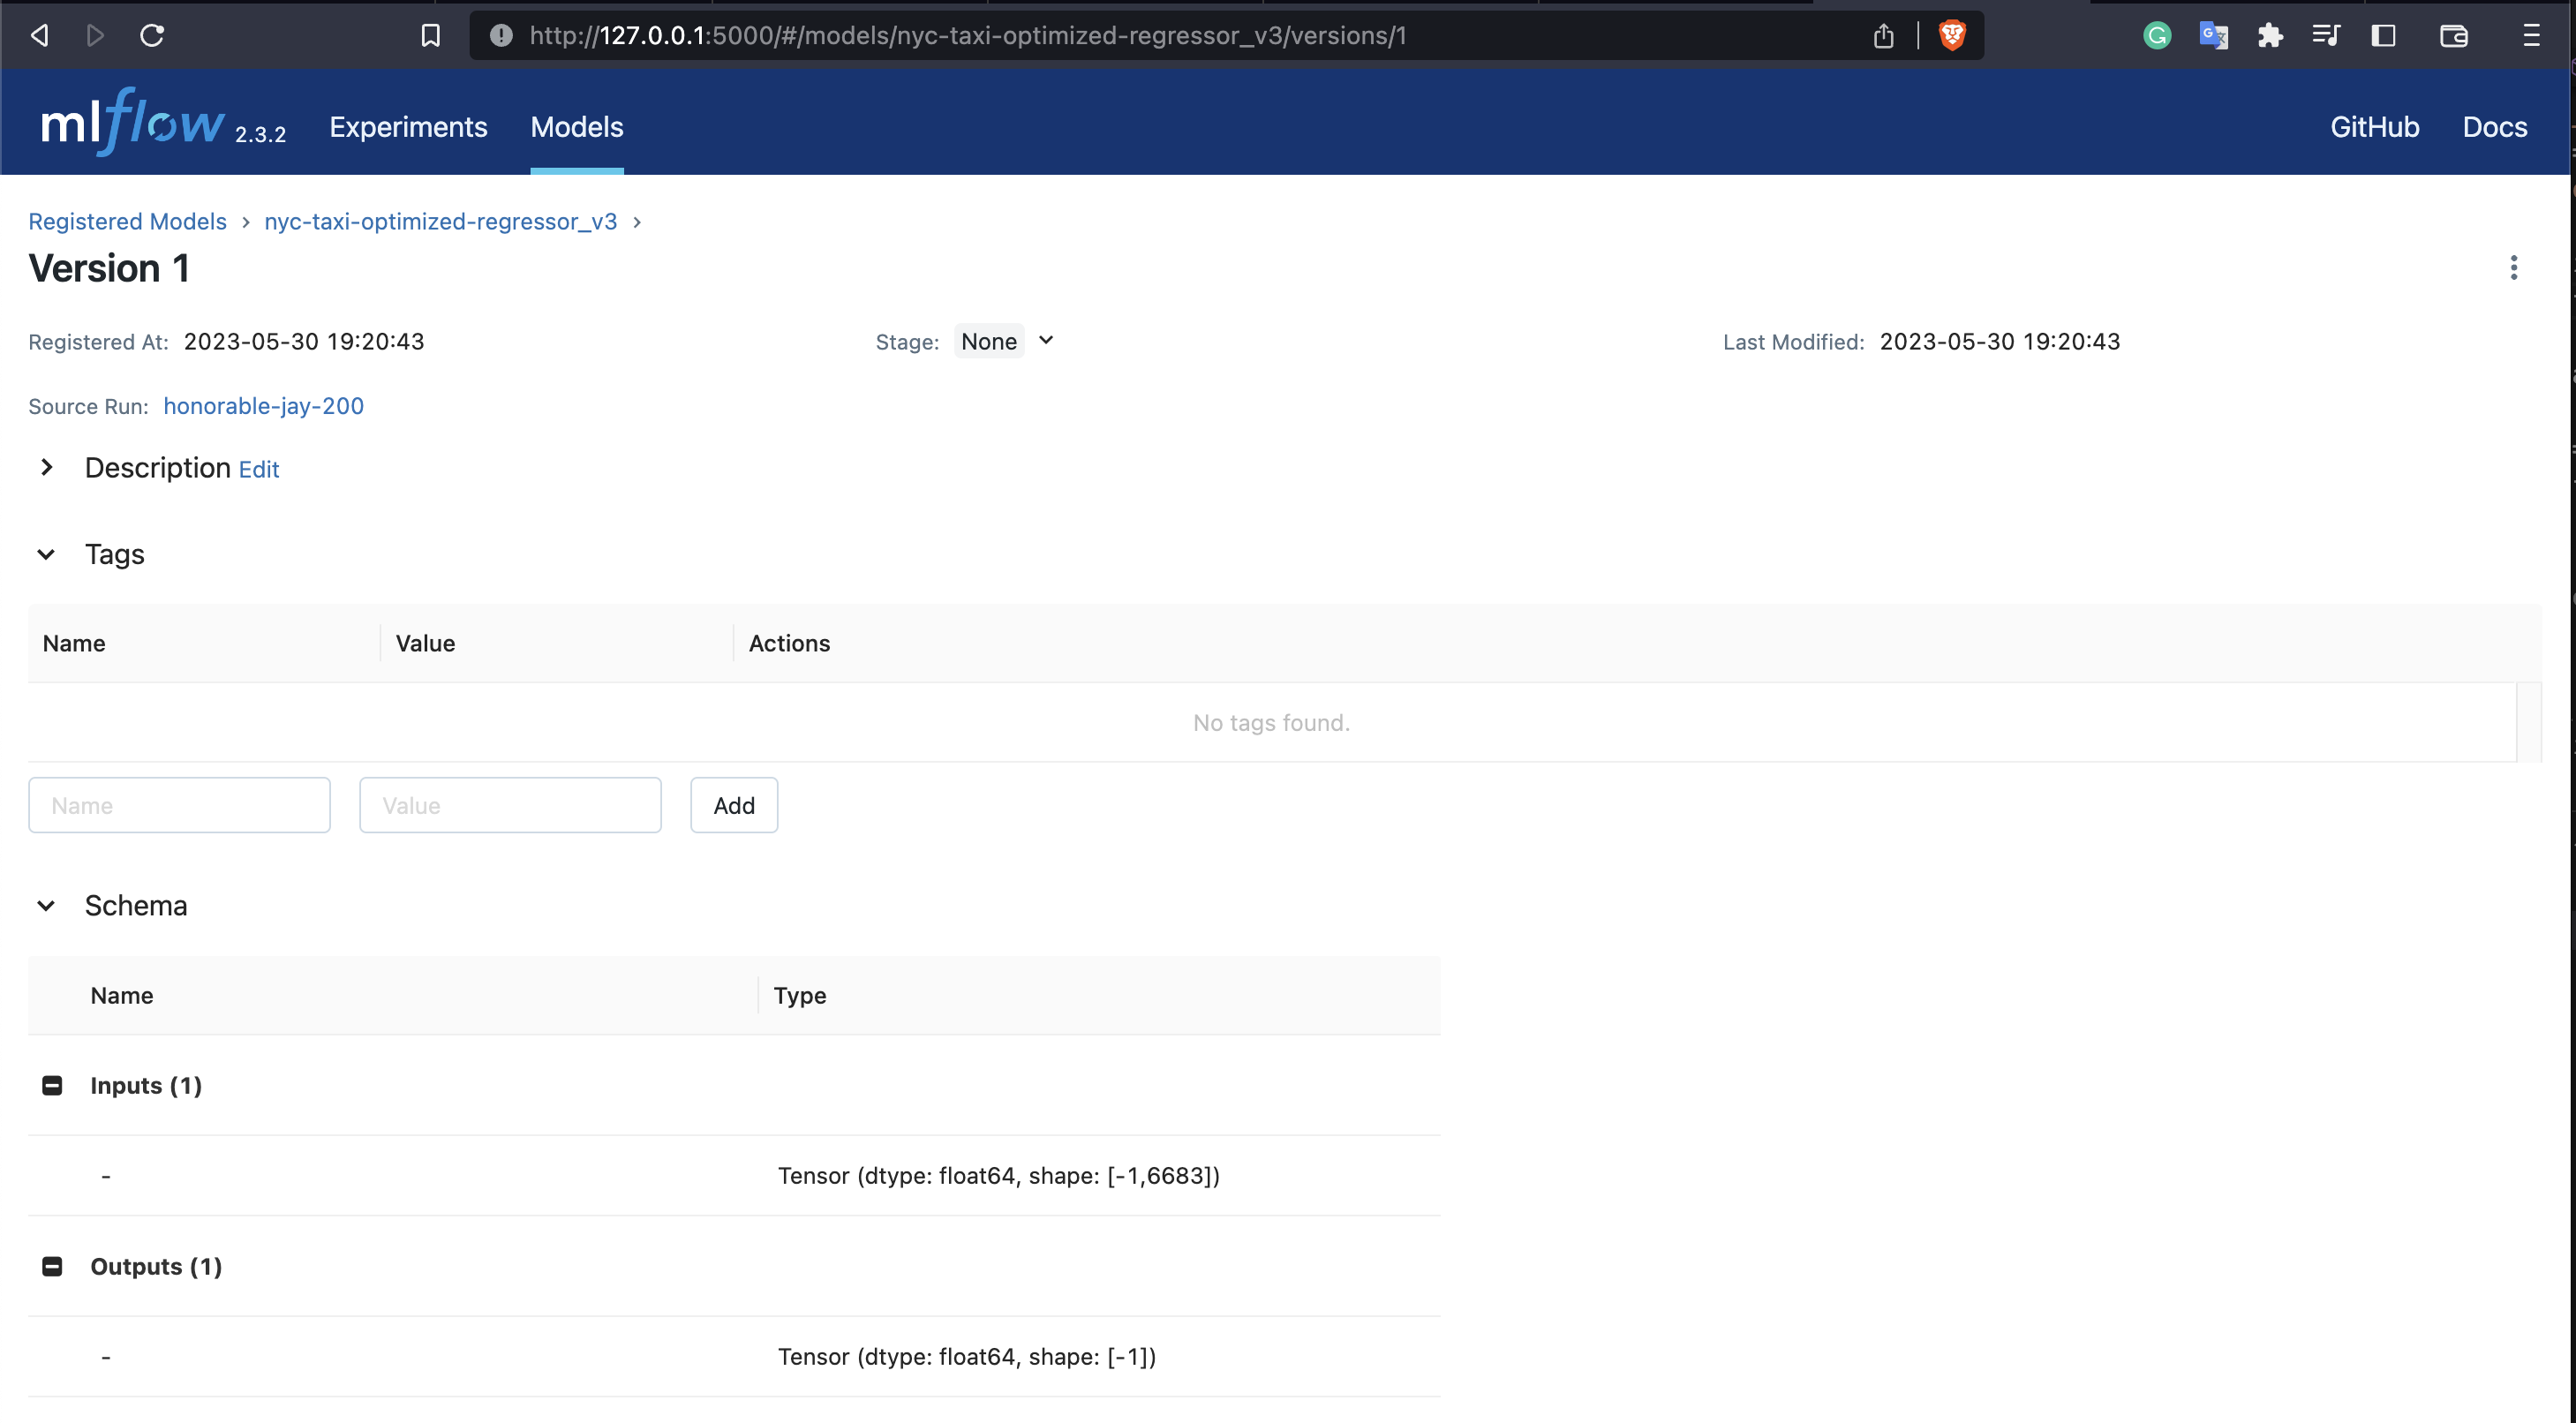